<a href="https://colab.research.google.com/github/AlexRostaing/TestEcoCO2/blob/master/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                   0
winter median co2 rate     39.000000
spring median co2 rate     40.000000
summer median co2 rate     39.000000
automn median co2 rate     40.000000
weekdays average co2 rate  39.502183
weekends average co2 rate  39.568651
                                   0
winter median co2 rate     39.599154
spring median co2 rate     39.349006
summer median co2 rate     39.383562
automn median co2 rate     39.769642
weekdays average co2 rate  39.486588
weekends average co2 rate  39.706944


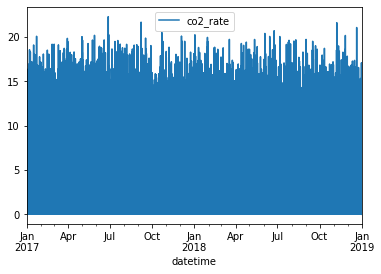

In [55]:
import requests
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
import numpy as np

#recuperation des donnees
url = "http://api-recrutement.ecoco2.com/v1/data?start=1483225200&end=1546297201"
response = requests.get(url)
original_data = response.json()

#transformation des dates en datetime et creation de la table horaire
hourly_data = []
for i in original_data:
    i['datetime'] = datetime.strptime(i['datetime'], "%Y-%m-%dT%H:%M:%S")
    if i['datetime'].minute == 0:
      hourly_data.append(i)

#creation du dataframe des donnees d'origine
df_original = pd.DataFrame(data=original_data)
df_original = df_original.set_index('datetime')
#print(df_original)

#creation du dataframe des donnees horaires
df = pd.DataFrame(data=hourly_data)
#ajout des demi-heures avec valeurs vides
df = df.set_index('datetime').asfreq('30Min')

#interpolation polynomiale
interpolated_poly2 = df.interpolate(method='polynomial', order=2)
#print(interpolated_poly2)

#creation du dataframe des differences entre les donnees d'origine et interpolees
df_diff = (df_original - interpolated_poly2).abs()
#print(df_diff)

#tracage des differences
df_diff.plot()
pyplot.show

#Creation des tableaux de medians

#Retourne les intervalles des saisons
def getSeasonsDates(x, season):
  if season == 'spring':
    return {'start':datetime(x,3,22),  'end':datetime(x,6,21)}
  elif season == 'summer':
    return {'start':datetime(x,6,22),  'end':datetime(x,9,21)}
  elif season == 'automn':
    return {'start':datetime(x,9,22),  'end':datetime(x,12,21)}

#Retourne un dataframe des medianes des saisons et la moyenne des jours ouvres et weekends
def getMedians(d):
  #tableau vides
  co2_winter = []
  co2_spring = []
  co2_summer = []
  co2_automn = []
  co2_weekdays = []
  co2_weekend = []
  #iteration du dataframme pour recuperer les donnees de chaque saison et de jours ouvers et weekends
  for i,r in d.iterrows():
    if i >= getSeasonsDates(i.year,'spring')['start'] and i <= getSeasonsDates(i.year,'spring')['end']:
      co2_spring.append(r['co2_rate'])
    elif i >= getSeasonsDates(i.year,'summer')['start'] and i <= getSeasonsDates(i.year,'summer')['end']:
      co2_summer.append(r['co2_rate'])
    elif i >= getSeasonsDates(i.year,'automn')['start'] and i <= getSeasonsDates(i.year,'automn')['end']:
      co2_automn.append(r['co2_rate'])
    else:
      co2_winter.append(r['co2_rate'])

    if i.weekday() >5:
      co2_weekend.append(r['co2_rate'])
    else:
      co2_weekdays.append(r['co2_rate'])

  #dictionnaire final contenant les medianes et moyennes
  data={'winter median co2 rate':np.median(co2_winter),
        'spring median co2 rate':np.median(co2_spring),
        'summer median co2 rate':np.median(co2_summer),
        'automn median co2 rate':np.median(co2_automn),
        'weekdays average co2 rate':(sum(co2_weekdays)/len(co2_weekdays)),
        'weekends average co2 rate':(sum(co2_weekend)/len(co2_weekend))}
  return pd.DataFrame.from_dict(data, orient='index')

#calcul des medianes et moyennes pour les donnees d'origine et interpolees
original_medians = getMedians(df_original)
print(original_medians)
interpolated_medians = getMedians(interpolated_poly2)
print(interpolated_medians)